# Financial Data Analysis

**Goal:** Get comfortable with data manipulation and visualization.\
**Skills Learned:** Pandas, Matplotlib, Seaborn, data cleaning.\
**Ideas:**
- Import historical stock prices (using yfinance) and compute returns, moving averages, and volatility.
- Compare multiple stocks’ performance over time.
- Calculate correlation between different assets.

### 1. Import libraries

In [42]:
from polygon import RESTClient
from dotenv import load_dotenv
from datetime import date
import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv() # loads .env file
api_key = os.getenv("POLYGON_API_KEY")
client = RESTClient(api_key)

### 2. Download stock price data

In [62]:
aggs = []
for a in client.list_aggs(
    "AAPL",
    1,
    "day",
    "2024-01-09",
    "2025-01-09",
    adjusted=True,
    sort="asc",
    limit=120,
):
    aggs.append(a)

# Convert list of Agg objects to DataFrame
data = pd.DataFrame([{
    "date": pd.to_datetime(a.timestamp, unit="ms"),
    "open": a.open,
    "high": a.high,
    "low": a.low,
    "close": a.close,
    "volume": a.volume,
    "vwap": a.vwap
} for a in aggs])

# Set the date as index
data.set_index("date", inplace=True)

# Preview
print(data.head())

                       open    high      low   close      volume      vwap
date                                                                      
2024-01-09 05:00:00  183.92  185.15  182.730  185.14  42841809.0  184.3706
2024-01-10 05:00:00  184.35  186.40  183.920  186.19  46792908.0  185.2403
2024-01-11 05:00:00  186.54  187.05  183.620  185.59  49128408.0  185.0604
2024-01-12 05:00:00  186.06  186.74  185.190  185.92  40477782.0  185.8199
2024-01-16 05:00:00  182.16  184.26  180.934  183.63  65603041.0  182.8825


### 3. Plot closing price

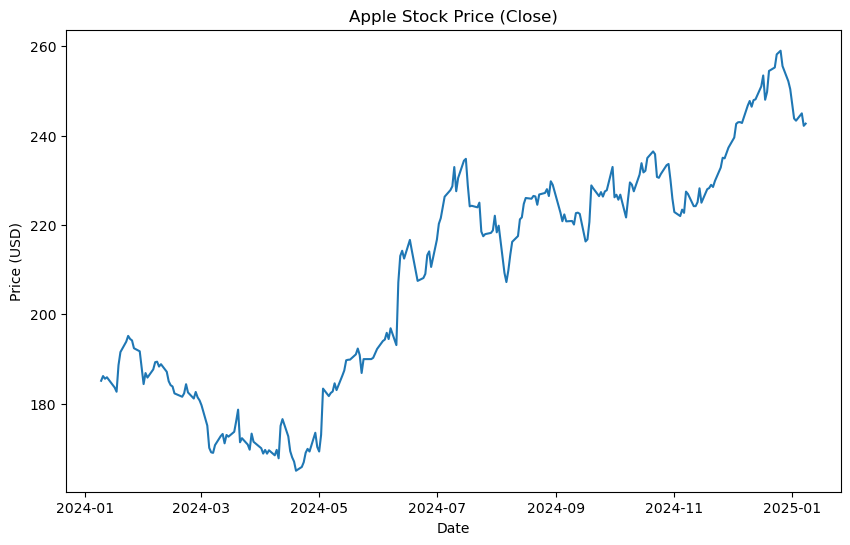

In [63]:
plt.figure(figsize=(10,6))
plt.plot(data['close'])
plt.title("Apple Stock Price (Close)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

### 4. Calculate daily returns

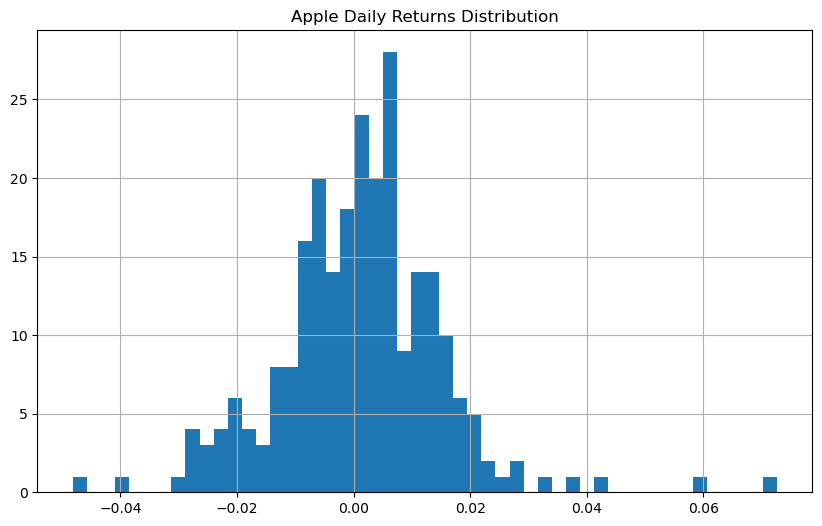

In [64]:
data['daily_return'] = data['close'].pct_change()

plt.figure(figsize=(10,6))
data['daily_return'].hist(bins=50)
plt.title("Apple Daily Returns Distribution")
plt.show()

### 5. Add moving averages

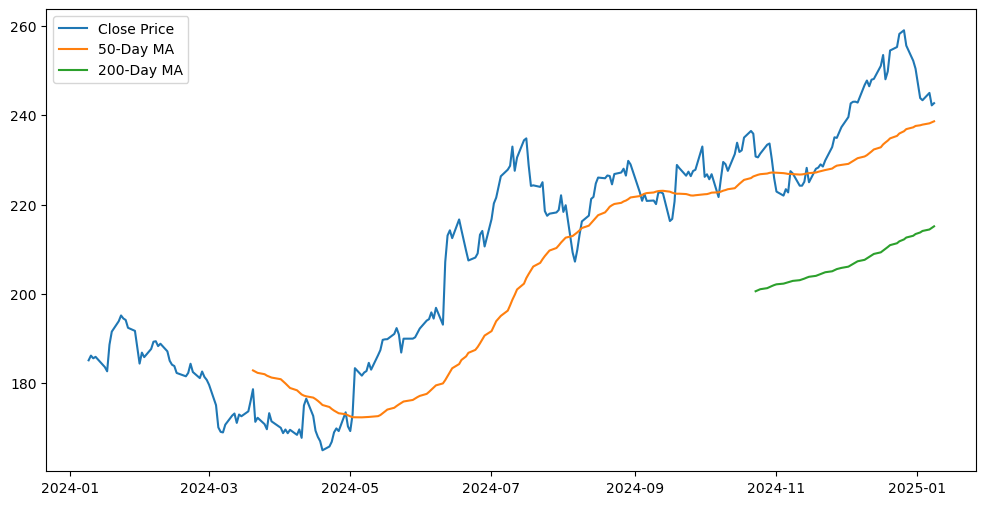

In [66]:
data['50MA'] = data['close'].rolling(50).mean()
data['200MA'] = data['close'].rolling(200).mean()

plt.figure(figsize=(12,6))
plt.plot(data['close'], label='Close Price')
plt.plot(data['50MA'], label='50-Day MA')
plt.plot(data['200MA'], label='200-Day MA')
plt.legend()
plt.show()

### 6. Compare multiple stocks

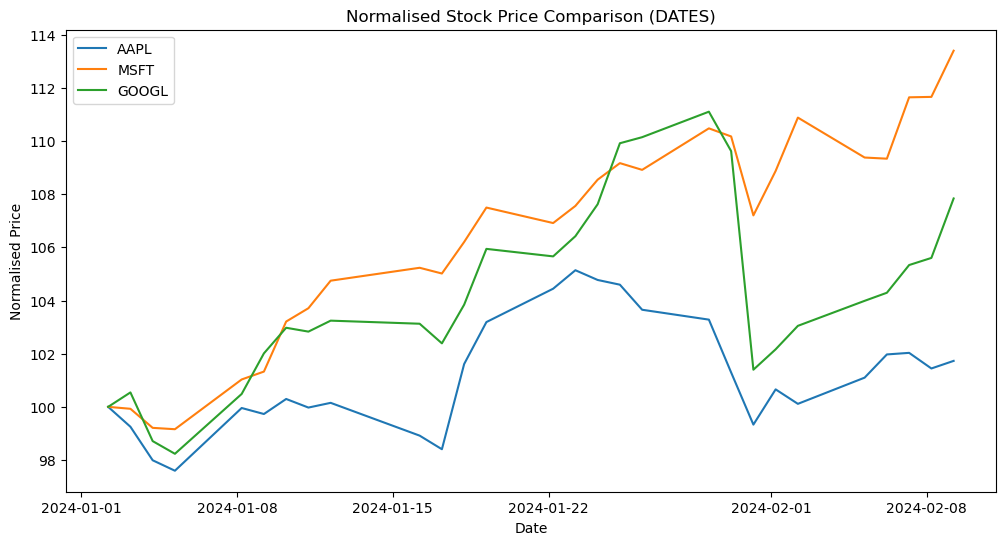

In [70]:
tickers = ["AAPL", "MSFT", "GOOGL"]
multi_data = {}

for ticker in tickers:
    aggs = list(client.list_aggs(
        ticker,
        1,                 # 1-day bars
        "day",
        "2024-01-01",
        "2024-02-10",
        adjusted=True,
        sort="asc",
        limit=120
    ))
    
    if len(aggs) == 0:
        print(f"No data for {ticker}")
        continue

    df = pd.DataFrame([{
    "date": pd.to_datetime(a.timestamp, unit="ms"),
    "close": a.close
    } for a in aggs])

    df.set_index("date", inplace=True)
    multi_data[ticker] = df['close']
    
# Combine all tickers into one DataFrame
combined = pd.DataFrame(multi_data)

# Normalise prices to 100 at start date for comparison
normalised = combined / combined.iloc[0] * 100

# Plot
plt.figure(figsize=(12,6))
for col in normalised.columns:
    plt.plot(normalised.index, normalised[col], label=col)
plt.title("Normalised Stock Price Comparison (DATES)")
plt.xlabel("Date")
plt.ylabel("Normalised Price")
plt.legend()
plt.show()

### 7. Correlation between stocks

Correlation matrix:
           AAPL      MSFT     GOOGL
AAPL   1.000000  0.455448  0.579402
MSFT   0.455448  1.000000  0.751693
GOOGL  0.579402  0.751693  1.000000


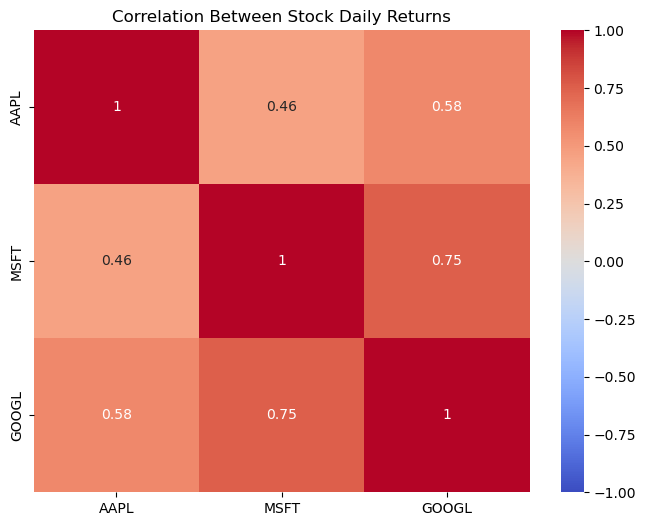

In [72]:
# Calculate daily returns
daily_returns = combined.pct_change().dropna() # pct_change computes daily returns

# Compute correlation matrix
corr_matrix = daily_returns.corr()

print("Correlation matrix:")
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Between Stock Daily Returns")
plt.show()